In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import shape
from shapely.geometry import box
from shapely.ops import unary_union
from tqdm import tqdm
from rasterio.plot import show
from rasterio.features import shapes
from rasterio.mask import mask
import rasterio
import yaml
import os

# Load configuration
with open('../../config.yaml', 'r') as file:
    config = yaml.safe_load(file)

def resolve_path(relative_path):
    return os.path.join(config['base_path'], relative_path)


Load, Reproject, Convert, Save Irrigation data

{'driver': 'AAIGrid', 'dtype': 'float32', 'nodata': -9.0, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]'), 'transform': Affine(0.08333333333333333, 0.0, -180.0,
       0.0, -0.08333333333333333, 90.0)}


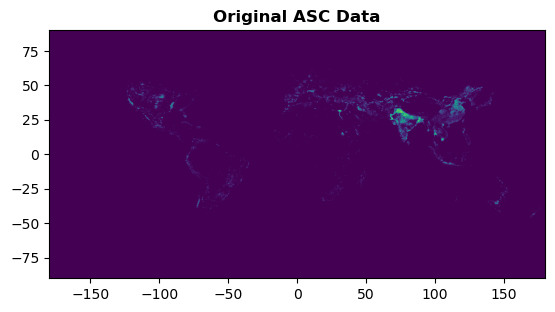

                                            geometry  raster_val
0  POLYGON ((-8.91667 38.00000, -8.91667 37.91667...   76.793549
1  POLYGON ((-8.83333 38.00000, -8.83333 37.91667...  199.917297
2  POLYGON ((-8.75000 38.00000, -8.75000 37.91667...   71.140877
3  POLYGON ((-8.66667 38.00000, -8.66667 37.91667...   29.676140
4  POLYGON ((-8.58333 38.00000, -8.58333 37.91667...  290.473785


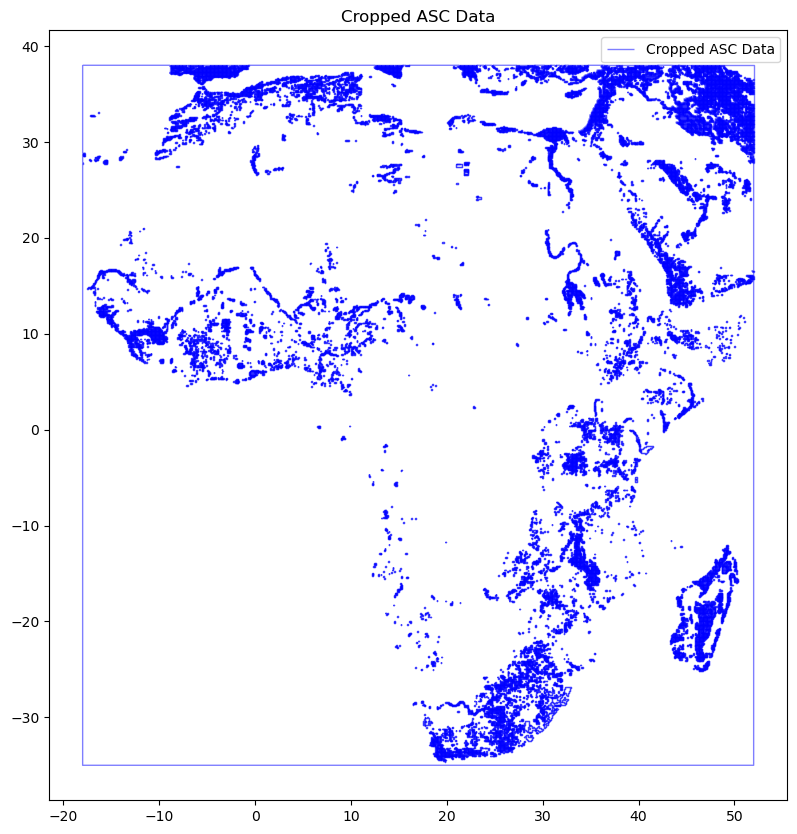

Reprojected CRS: EPSG:3857
Reprojected Bounding Box: [-2003750.83427892 -4163881.14406429  5788613.52125023  4579425.8128701 ]


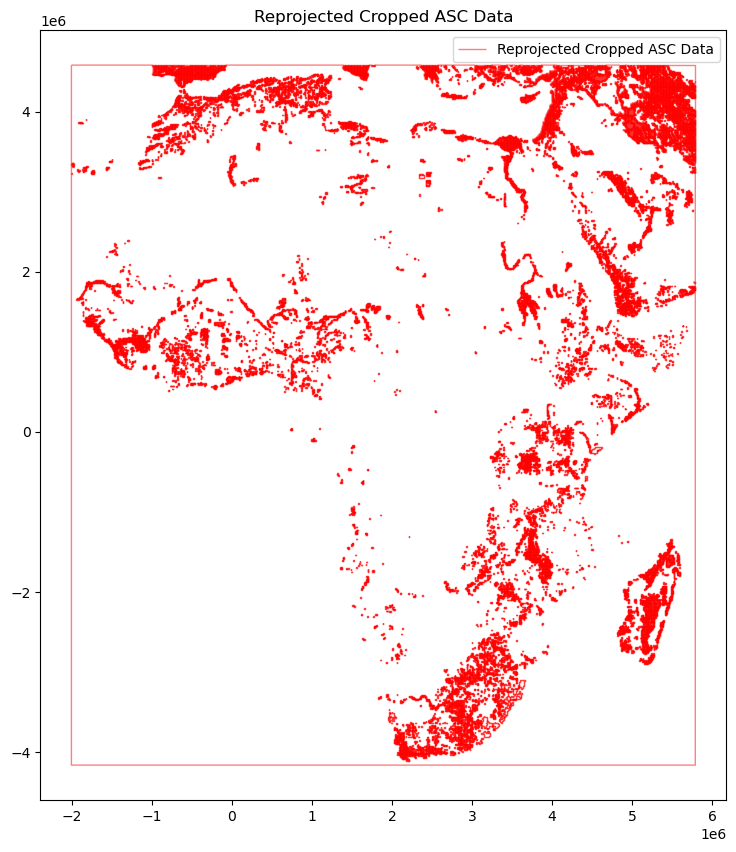

Original Geometries:
 0    POLYGON ((-8.91667 38.00000, -8.91667 37.91667...
1    POLYGON ((-8.83333 38.00000, -8.83333 37.91667...
2    POLYGON ((-8.75000 38.00000, -8.75000 37.91667...
3    POLYGON ((-8.66667 38.00000, -8.66667 37.91667...
4    POLYGON ((-8.58333 38.00000, -8.58333 37.91667...
Name: geometry, dtype: geometry
Reprojected Geometries:
 0    POLYGON ((-992598.793 4579425.813, -992598.793...
1    POLYGON ((-983322.169 4579425.813, -983322.169...
2    POLYGON ((-974045.544 4579425.813, -974045.544...
3    POLYGON ((-964768.920 4579425.813, -964768.920...
4    POLYGON ((-955492.296 4579425.813, -955492.296...
Name: geometry, dtype: geometry
GeoPackage saved to: /home/waves/data/Africa_Irrigation/Data/Processed/G_AEI_2015_Reprojected.gpkg


In [2]:
# Load and Read the ASC file
asc_file_path = resolve_path(config['Africa_AEI_2015_asc_path'])

with rasterio.open(asc_file_path) as src:
    asc_data = src.read(1)  # Read the first band
    asc_meta = src.meta
    print(asc_meta)
    show(src, title="Original ASC Data")

# Define the bounding box for Africa
africa_bbox = (-18.0, -35.0, 52.0, 38.0)  # (min_lon, min_lat, max_lon, max_lat)

# Create a bounding box geometry
bbox_geom = box(*africa_bbox)
geo = gpd.GeoDataFrame({'geometry': [bbox_geom]}, index=[0], crs='EPSG:4326')

# Reproject the bounding box to the ASC file CRS if necessary
if asc_meta['crs'] != geo.crs:
    geo = geo.to_crs(crs=asc_meta['crs'])

# Crop the ASC data using the bounding box
with rasterio.open(asc_file_path) as src:
    out_image, out_transform = mask(src, [bbox_geom], crop=True)
    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

# Save the cropped ASC data to a new file
cropped_asc_path = resolve_path(config['AEI_2015_cropped_tif_path'])
with rasterio.open(cropped_asc_path, 'w', **out_meta) as dest:
    dest.write(out_image)

# Convert the cropped ASC data to GeoDataFrame
def raster_to_geodataframe(raster_path, crs):
    with rasterio.open(raster_path) as src:
        image = src.read(1)  # Read the first band
        mask = image != src.nodata
        results = (
            {'properties': {'raster_val': v}, 'geometry': shape(s)}
            for i, (s, v) in enumerate(shapes(image, mask=mask, transform=src.transform))
        )
        geoms = list(results)
        gdf = gpd.GeoDataFrame.from_features(geoms)
        gdf.crs = crs
    return gdf

gdf_cropped_asc = raster_to_geodataframe(cropped_asc_path, asc_meta['crs'])
print(gdf_cropped_asc.head())

# Plot the cropped GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 10))
gdf_cropped_asc.boundary.plot(ax=ax, linewidth=1, edgecolor='blue', alpha=0.5, label='Cropped ASC Data')
plt.title('Cropped ASC Data')
plt.legend()
plt.show()

# Reproject the cropped GeoDataFrame to a new CRS (EPSG:3857)
gdf_cropped_asc_reprojected = gdf_cropped_asc.to_crs(epsg=3857)

# Print CRS and bounding box after reprojection
print("Reprojected CRS:", gdf_cropped_asc_reprojected.crs)
print("Reprojected Bounding Box:", gdf_cropped_asc_reprojected.total_bounds)

# Plot the reprojected GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 10))
gdf_cropped_asc_reprojected.boundary.plot(ax=ax, linewidth=1, edgecolor='red', alpha=0.5, label='Reprojected Cropped ASC Data')
plt.title('Reprojected Cropped ASC Data')
plt.legend()
plt.show()

# Inspect some geometries before and after reprojection
print("Original Geometries:\n", gdf_cropped_asc.geometry.head())
print("Reprojected Geometries:\n", gdf_cropped_asc_reprojected.geometry.head())

# Define the path to save the GeoPackage
geopackage_path = resolve_path(config['AEI_2015_reproj_gpkg_path'])

# Save the reprojected GeoDataFrame as a GeoPackage
gdf_cropped_asc_reprojected.to_file(geopackage_path, driver="GPKG")

print(f"GeoPackage saved to: {geopackage_path}")


Crop Irrigation data to Different Aridity Layers

In [3]:
def faster_clip(aei_gdf, clip_gdf):
    # Create a unary union of the clip geometries
    clip_union = unary_union(clip_gdf.geometry)

    # Filter geometries that intersect the clipping area with a progress bar
    intersects = []
    for geom in tqdm(aei_gdf.geometry, desc="Checking Intersections", unit="geoms"):
        intersects.append(geom.intersects(clip_union))
    
    filtered_gdf = aei_gdf[intersects].copy()

    # Perform the intersection with a progress bar
    for i in tqdm(range(len(filtered_gdf)), desc="Performing Intersections", unit="geoms"):
        filtered_gdf.iloc[i, filtered_gdf.columns.get_loc('geometry')] = filtered_gdf.iloc[i].geometry.intersection(clip_union)

    return filtered_gdf

def process_layer(layer_name, config, aei_gdf):
    # Resolve the paths for the shapefile and output file
    shp_path = resolve_path(config[f'Africa_{layer_name}_shp_path'])
    output_path = resolve_path(config[f'{layer_name}_AEI_2015_shp_path'])

    # Load the shapefile for the current layer
    gdf_shp = gpd.read_file(shp_path)

    # Check and reproject CRS if necessary
    if aei_gdf.crs != gdf_shp.crs:
        gdf_shp = gdf_shp.to_crs(aei_gdf.crs)

    # Perform the faster clip operation using Shapely's intersection
    gdf_cropped = faster_clip(aei_gdf, gdf_shp)

    # Save the clipped data to a new file as a shapefile
    gdf_cropped.to_file(output_path, driver='ESRI Shapefile')

    print(f"{layer_name} layer processed and saved to {output_path}")

# Define aridity layers
layers = ['Semi_Arid', 'Arid', 'Hyper_Arid', 'All']

# Load the main dataset
aei_gdf = gpd.read_file(resolve_path(config['AEI_2015_reproj_gpkg_path']))

# Iterate through each layer and process it with a progress bar
for layer in tqdm(layers, desc="Processing Layers"):
    process_layer(layer, config, aei_gdf)


Processing Layers:  25%|██▌       | 1/4 [02:24<07:12, 144.07s/it]

Semi_Arid layer processed and saved to /home/waves/data/Africa_Irrigation/Data/Processed/G_AEI_2015_Aridity_Layers-shp/G_AEI_2015_Semi_Arid.shp


Processing Layers:  50%|█████     | 2/4 [03:32<03:18, 99.33s/it] 

Arid layer processed and saved to /home/waves/data/Africa_Irrigation/Data/Processed/G_AEI_2015_Aridity_Layers-shp/G_AEI_2015_Arid.shp


Processing Layers:  75%|███████▌  | 3/4 [03:53<01:03, 63.73s/it]

Hyper_Arid layer processed and saved to /home/waves/data/Africa_Irrigation/Data/Processed/G_AEI_2015_Aridity_Layers-shp/G_AEI_2015_Hyper_Arid.shp


Processing Layers: 100%|██████████| 4/4 [07:51<00:00, 117.94s/it]

All layer processed and saved to /home/waves/data/Africa_Irrigation/Data/Processed/G_AEI_2015_Aridity_Layers-shp/G_AEI_2015_All_Arid.shp
